#### detection -> crop predicted images

참고) https://docs.ultralytics.com/reference/engine/results/#ultralytics.engine.results.BaseTensor.numpy

#### color extraction
* https://github.com/CairX/extract-colors-py?tab=readme-ov-file#id14
* https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py
* https://webcolors.readthedocs.io/en/latest/contents.html
* https://matplotlib.org/stable/users/explain/colors/colors.html
* https://xkcd.com/color/rgb/


In [411]:
import os
import extcolors
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import matplotlib.colors as mcolors
import pandas as pd

from ultralytics import YOLO

import torch
from torchvision.transforms import v2 # pytorch

In [435]:
# def ################################################################################

# detection과 object부분 크롭
def crop_imgs(img_path, custom_model):
    model = YOLO(custom_model)  # load a pretrained YOLOv8n detection model

    # model.train(data='coco128.yaml', epochs=3)  # train the model
    model.predict(img_path, save_crop=True)  # predict on an image 
    # 추가 파라미터: save_txt=True, show=True 사용 가능

    # # Extract bounding boxes, classes, names, and confidences
    # boxes = results[0].boxes.xyxy.tolist()
    # classes = results[0].boxes.cls.tolist()
    # names = results[0].names
    # confidences = results[0].boxes.conf.tolist()

    # # Iterate through the results
    # for box, cls, conf in zip(boxes, classes, confidences):
    #     x1, y1, x2, y2 = box
    #     confidence = conf
    #     detected_class = cls
    #     name = names[int(cls)]


# XKCD COLORS info를 df로 생성
def colors_df():
  global df
  df = pd.DataFrame(columns=['name','red','green','blue'])
  for color_name, color_hex in mcolors.XKCD_COLORS.items():
      r, g, b = mcolors.to_rgb(color_hex)
      df = pd.concat([df, pd.DataFrame({'name':[color_name], 'red':[r], 'green':[g], 'blue':[b]})], ignore_index= True)
  return df

# 가까운 색상명
def closest_color(rgb):
  differences = {}
  for color_name, color_hex in mcolors.XKCD_COLORS.items(): # mcolors.CSS4_COLORS mcolors.XKCD_COLORS
    r, g, b = mcolors.to_rgb(color_hex)

    differences[sum([(r*255-rgb[0])**2,
                    (g*255-rgb[1])**2,
                    (b*255-rgb[2])**2])] = color_name
    
  return differences[min(differences.keys())]



# 이미지 색상명 추출
def find_colorname(item, croppedfolder):
  top_img = os.listdir(croppedfolder + item)[0]
  top_img_path = croppedfolder + item + '/' + top_img

  org_img = Image.open(top_img_path)

  # 원본 이미지 사이즈 구하기
  org_img_size = v2.functional.get_size(org_img)

  # 가로, 세로 중 짧은 쪽의 80% 길이로 만들기
  size_80 = min(org_img_size[0], org_img_size[1]) * 0.8
  centercrop = v2.CenterCrop(size_80)
  img_size80 = centercrop(org_img)

  # plt.imshow(img_size80)

  # 색상 추출
  colors, pixel_count = extcolors.extract_from_image(img_size80)

  # output
  clothes_color = closest_color(colors[0][0])

  # check the colors
  # rgb_list = [colors[0][0]] # 가장 많은 컬러
  # one_px = np.array(rgb_list)[np.newaxis, :, :]

  # plt.imshow(np.array(one_px))
  # plt.axis('off')
  # plt.show()
  return clothes_color


# 파일명 없으면 생성
def makedirs(path):
    if not os.path.exists(path):
        os.makedirs(path)


In [ ]:
# run ###############################################

# 색상, 옷 카테고리 결과 담을 df
result = pd.DataFrame(columns=['img_path','top_category','top_color','bottom_category','bottom_color'])

# source info
image_folder = '..\\object_detection\\ClothesCategory_v9\\test\\images\\'
custom_model = '..\\object_detection\\runs\\detect\\datav5result\\weights\\best.pt'

for img in os.listdir(image_folder):
    image_source = image_folder + img

    try:
        # object에 맞게 이미지 크롭
        crop_imgs(image_source, custom_model)

        # 크롭된 이미지의 위치
        cropped_folder = r'./runs/detect/predict/crops/'
        for item in os.listdir(cropped_folder): # 해당 폴더 내 모든 파일 및 폴더 추출
            # item: 옷 카테고리명
            color = find_colorname(item, cropped_folder)
            if item in ['shirt','sweater','mtm','hoodies','longsleeve','shortsleeve','jacket','blazer','padding','zipup','cardigan','coat']:
                top = {'item':item, 'color':color}
            else: # skirt, denim pants, cotton pants, trainingpants, slacks, short pants
                bottom = {'item':item, 'color':color}

        # result df에 추가
        result = pd.concat([result, pd.DataFrame({'img_path':[image_source],'top_category':[top.get('item')],
                                                'top_color':[top.get('color')],'bottom_category':[bottom.get('item')],
                                                'bottom_color':[bottom.get('color')]})], ignore_index= True)
            
        # cropped_folder 삭제
        import shutil
        shutil.rmtree(r'./runs/')
    except:
        continue



In [438]:
result.to_csv('./result.csv',index=False, encoding='utf-8')

#### color clustering: dbscan (best)

In [398]:
colors_df()

# df 행 셔플
df = df.sample(frac=1)

In [402]:
from sklearn.cluster import DBSCAN

model = DBSCAN(eps=0.09, min_samples=3)

data = df.drop(columns='name')

model.fit(data)

df['cluster'] = model.fit_predict(data)

In [403]:
len(df['cluster'].unique())

79

In [404]:
df['cluster'].value_counts()

-1     152
 7     104
 17     42
 18     23
 5      23
      ... 
 15      3
 52      3
 72      3
 49      3
 74      3
Name: cluster, Length: 79, dtype: int64

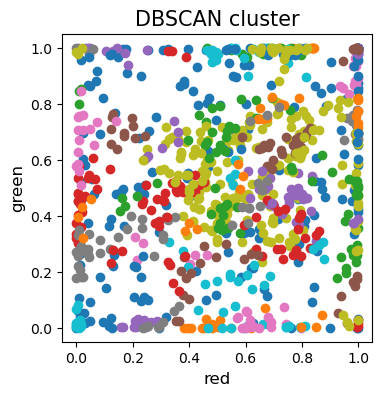

In [405]:
import matplotlib.pyplot as plt

plt.figure(figsize = (4, 4))

# 이상치 번호는 -1, 클러스터 최대 숫자까지 iteration
for i in range(-1, df['cluster'].max() + 1):
    plt.scatter(df.loc[df['cluster'] == i, 'red'], df.loc[df['cluster'] == i, 'green'], 
                    label = 'cluster ' + str(i))

# plt.legend()
plt.title('DBSCAN cluster', size = 15)
plt.xlabel('red', size = 12)
plt.ylabel('green', size = 12)
plt.show()

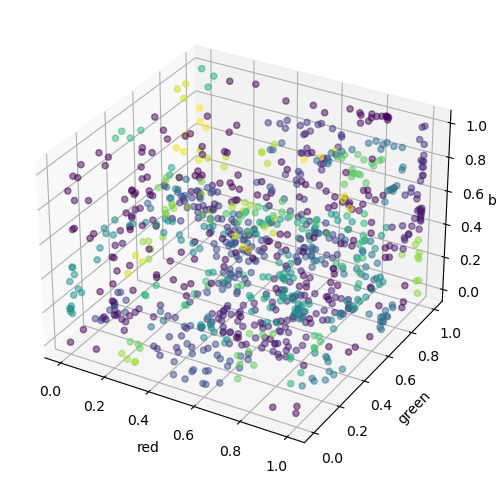

In [406]:
from mpl_toolkits.mplot3d import Axes3D
# scatter plot
fig = plt.figure( figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(df['red'],df['green'],df['blue'],c=df['cluster'], alpha=0.5)
ax.set_xlabel('red')
ax.set_ylabel('green')
ax.set_zlabel('blue')
plt.show()

In [407]:
# eps=0.1, min_samples=2
# eps=0.1, min_samples=5
# eps=0.1, min_samples=10 
# eps=0.09, min_samples=10
# eps=0.09, min_samples=3 (this)
df.to_csv('./cluster.csv',encoding='utf-8',index=False)

#### color clustering: kmeans

In [13]:
from sklearn.cluster import KMeans

colors_df()

model = KMeans(n_clusters=30)

data = df.drop(columns='name')

model.fit(data)

df['cluster'] = model.fit_predict(data)

c:\Users\Andlab\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Andlab\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\Andlab\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Andlab\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there

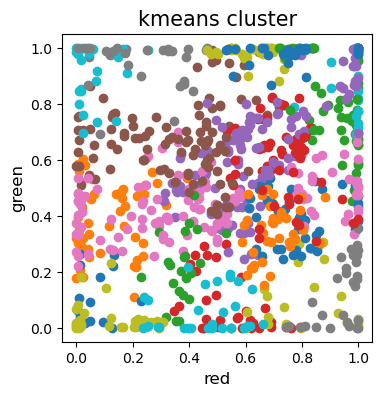

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize = (4, 4))

# 이상치 번호는 -1, 클러스터 최대 숫자까지 iteration
for i in range(-1, df['cluster'].max() + 1):
    plt.scatter(df.loc[df['cluster'] == i, 'red'], df.loc[df['cluster'] == i, 'green'], 
                    label = 'cluster ' + str(i))

# plt.legend()
plt.title('kmeans cluster', size = 15)
plt.xlabel('red', size = 12)
plt.ylabel('green', size = 12)
plt.show()

In [15]:
df['name'][df['cluster'] == 1]

15     xkcd:macaroni and cheese
75              xkcd:sun yellow
78            xkcd:butterscotch
87                  xkcd:squash
95               xkcd:orangeish
118         xkcd:orangey yellow
139       xkcd:sunflower yellow
170             xkcd:golden rod
209              xkcd:dandelion
216            xkcd:piss yellow
229                xkcd:saffron
251              xkcd:sunflower
324           xkcd:faded orange
328                  xkcd:mango
360          xkcd:pastel orange
361       xkcd:yellowish orange
421                 xkcd:golden
481         xkcd:pumpkin orange
522          xkcd:orange yellow
536           xkcd:burnt yellow
565                  xkcd:amber
626               xkcd:marigold
679          xkcd:golden yellow
741          xkcd:yellow orange
756              xkcd:tangerine
785            xkcd:pale orange
850         xkcd:mustard yellow
858              xkcd:goldenrod
859            xkcd:dark yellow
870           xkcd:light orange
888                   xkcd:gold
940     

#### merge dataset

In [439]:
cluster= pd.read_csv('./cluster.csv').drop(columns=['red','blue','green'])
result = pd.read_csv('./result.csv')

In [440]:
result = pd.merge(result, cluster, how='left', left_on='top_color', right_on='name').drop(columns='name').rename(columns={'cluster':'top_color_cluster'})
result = pd.merge(result, cluster, how='left', left_on='bottom_color', right_on='name').drop(columns='name').rename(columns={'cluster':'bottom_color_cluster'})
result[:10]

img_path top_category  \
0  ..\object_detection\ClothesCategory_v9\test\im...   longsleeve   
1  ..\object_detection\ClothesCategory_v9\test\im...       blazer   
2  ..\object_detection\ClothesCategory_v9\test\im...   longsleeve   
3  ..\object_detection\ClothesCategory_v9\test\im...  shortsleeve   
4  ..\object_detection\ClothesCategory_v9\test\im...  shortsleeve   
5  ..\object_detection\ClothesCategory_v9\test\im...  shortsleeve   
6  ..\object_detection\ClothesCategory_v9\test\im...        shirt   
7  ..\object_detection\ClothesCategory_v9\test\im...  shortsleeve   
8  ..\object_detection\ClothesCategory_v9\test\im...  shortsleeve   
9  ..\object_detection\ClothesCategory_v9\test\im...  shortsleeve   

              top_color bottom_category        bottom_color  \
0  xkcd:light grey blue      shortpants         xkcd:marine   
1  xkcd:light blue grey          slacks           xkcd:dark   
2         xkcd:bluegrey      shortpants   xkcd:almost black   
3             xkcd:dark      shortpants  xkcd:charcoal grey   
4     xkcd:almost black     cottonpants      xkcd:dark grey   
5        xkcd:pale grey      shortpants           xkcd:dark   
6       xkcd:light grey      shortpants   xkcd:almost black   
7             xkcd:dark      shortpants        xkcd:reddish   
8             xkcd:dark      denimpants  xkcd:charcoal grey   
9     xkcd:brick orange           skirt         xkcd:marine   

   top_color_cluster  bottom_color_cluster  
0                 76                    36  
1                 76                    -1  
2                 19                    -1  
3                 -1                    49  
4                 -1                    49  
5                  9                    -1  
6                 -1                    -1  
7                 -1                    42  
8                 -1                    49  
9                  7                    36

In [441]:
result.to_csv('./result_colorclustering.csv',encoding='utf-8',index=False)

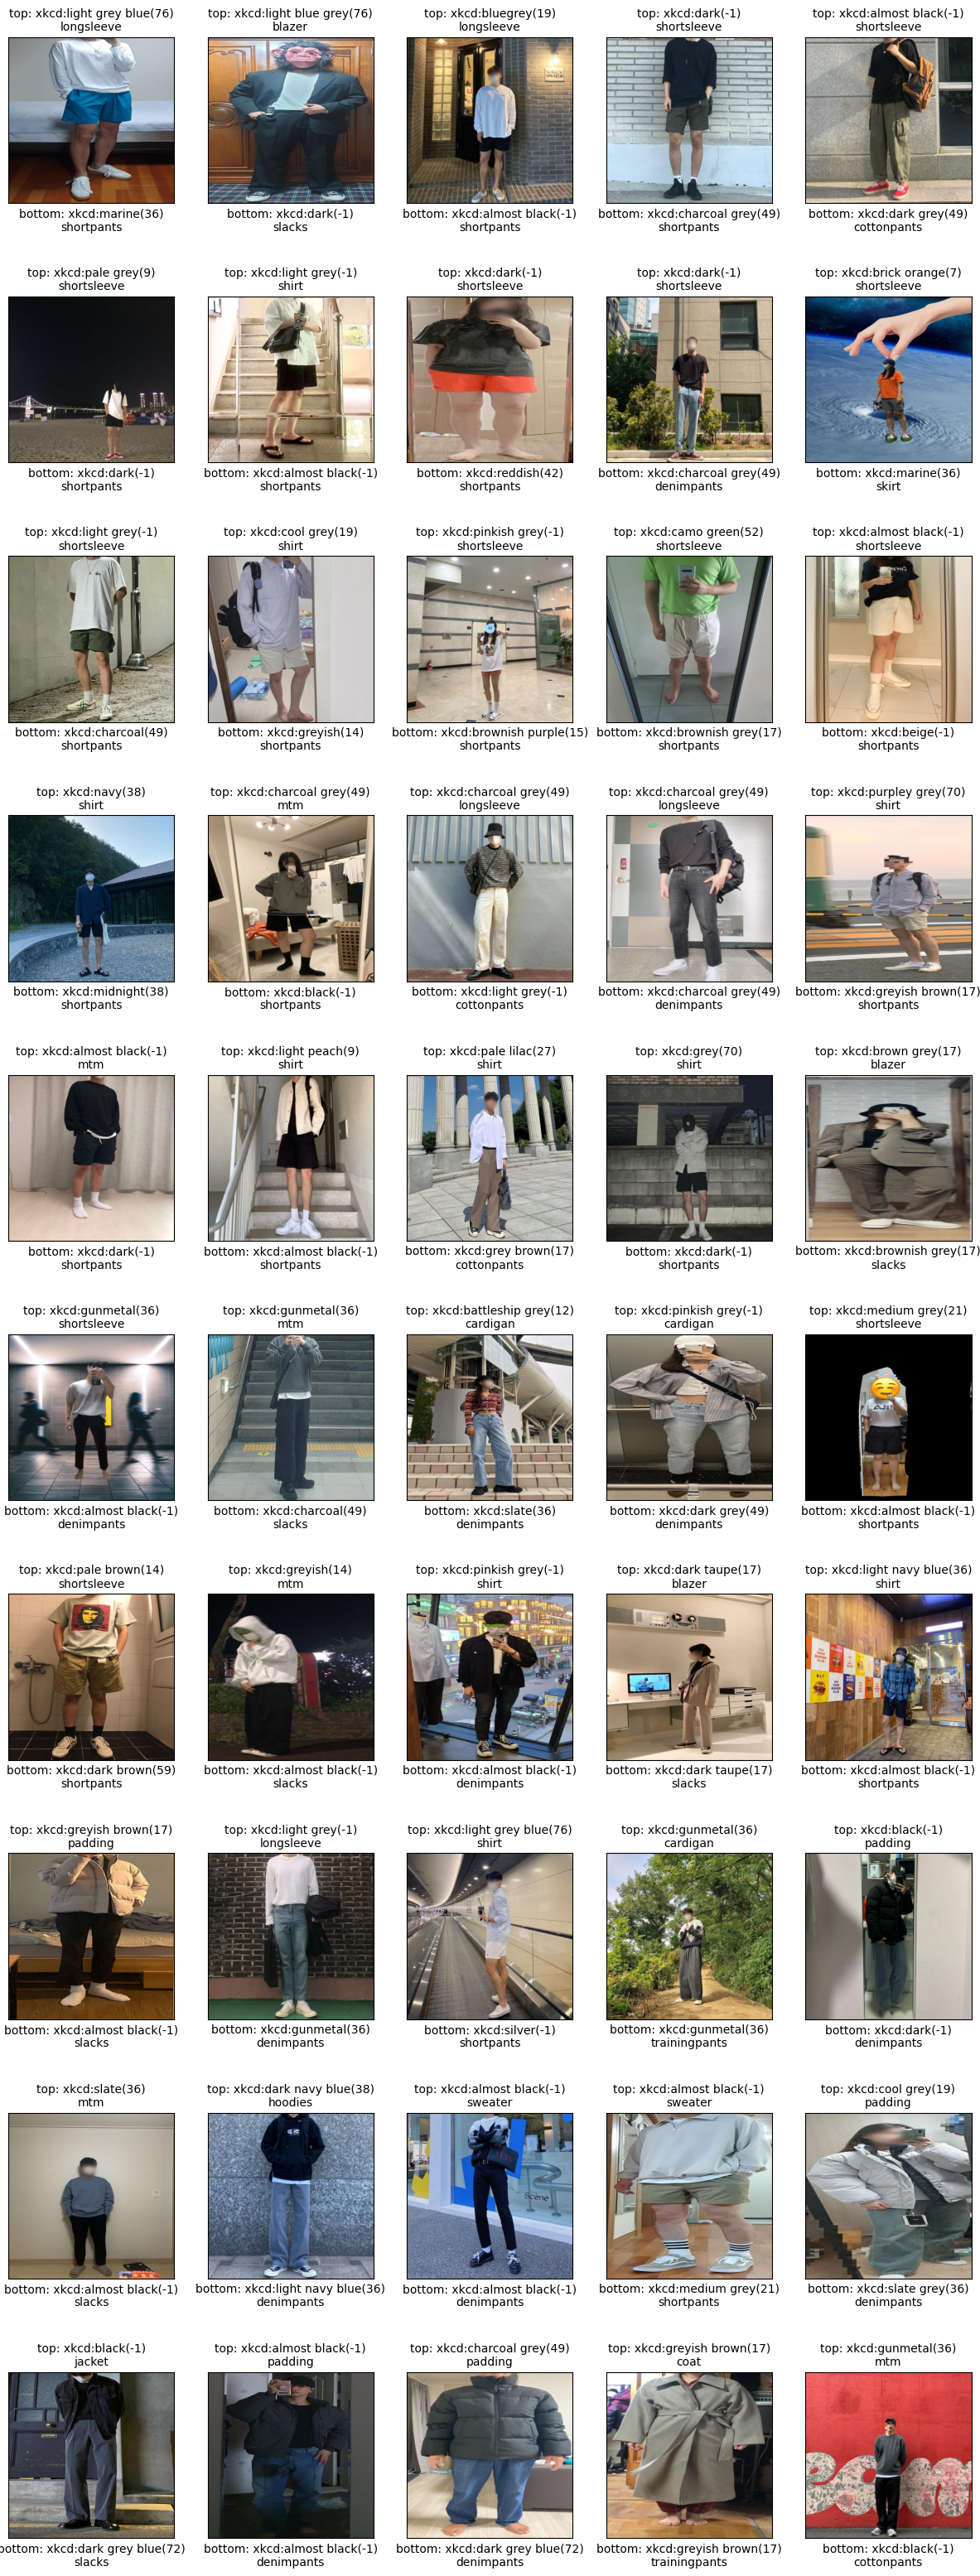

In [453]:
from PIL import Image
import matplotlib.pyplot as plt

# // %matplotlib inline

plt.rcParams['figure.figsize'] = (15.0, 40.0)



# struct is  [10, 5]
rows = 10
columns = 5

for i in range(len(result[:50])) : 
    image = Image.open(result['img_path'][i])
    image_index = i + 1     # image index 
    ttitle = f"top: {result['top_color'][i]}({result['top_color_cluster'][i]})\n{result['top_category'][i]}" # image title
    plt.subplot(rows, columns, image_index) # subplot 
    plt.title(ttitle, fontsize=10)   # title 
    # // plt.axis('off')
    plt.xticks([])  # x = None 
    plt.yticks([])  # y = None
    plt.xlabel(f"bottom: {result['bottom_color'][i]}({result['bottom_color_cluster'][i]})\n{result['bottom_category'][i]}", fontsize=10)
    plt.imshow(image)

plt.show()

In [427]:
result[['top_color','bottom_color']].value_counts()

top_color          bottom_color     
xkcd:almost black  xkcd:almost black    122
                   xkcd:dark             71
xkcd:dark          xkcd:almost black     56
                   xkcd:dark             56
xkcd:black         xkcd:almost black     25
                                       ... 
xkcd:dark olive    xkcd:gunmetal          1
                   xkcd:light grey        1
                   xkcd:medium grey       1
xkcd:dark plum     xkcd:almost black      1
xkcd:white         xkcd:pinkish grey      1
Length: 934, dtype: int64

In [426]:
result[['top_color_cluster','bottom_color_cluster']].value_counts()

top_color_cluster  bottom_color_cluster
-1                 -1                      636
                    49                      95
                    36                      83
 49                -1                       64
-1                  17                      51
                                          ... 
 30                 49                       1
 0                  76                       1
 36                 9                        1
                    21                       1
 21                 72                       1
Length: 288, dtype: int64

In [ ]:
# 어떤 카테고리 + 색감이 가장 많았는지
# 색감별로 보여주기
# 카테고리별 보여주기